In [1]:
#Pk/Pd Simulation

#This one-compartment PK modeling is inspired by https://colab.research.google.com/github/jckantor/CBE30338/blob/master/docs/03.05-One-Compartment-Pharmacokinetics.ipynb#scrollTo=ZGTGkRGQIj8Z

#Generating data from a model for repeated dosing

#The goal is to compare LSTM neural networks for PK/PD modeling vs Random Forest in sufficiently
#large data limit

import numpy as np
from scipy.integrate import odeint
from scipy.interpolate import interp1d
import random

#Total span of time space up to 200 hours from first administration
t = np.linspace(0, 200, 1000)

# Function definition for dosing
def u_constant(t, Udose, tdose, td):
    if t % tdose <= td:
        return Udose / td
    else:
        return 0

def u_pulse(t, Udose, tdose, td):
    if t % tdose == 0:
        return Udose / td
    else:
        return 0

def u_decay(t, Udose, tdose, td):
    if t % tdose <= td:
        return Udose / td * np.exp(-(t % tdose) / td)
    else:
        return 0

# Define the derivative function for concentration change
def deriv(C, t, u_func, Udose, tdose, td):
    k = 0.1  # Example elimination rate constant
    dCdt = -k * C + u_func(t, Udose, tdose, td)
    return dCdt

# Initial concentration
Cinitial = 0
#Number of regimen possibilities we want to simulate
num_regimens = 10000

parameter_combinations = []
for _ in range(num_regimens):
    td = random.uniform(1, 5)  # Random length of administration for a single dose between 1 and 5 hours
    tdose = random.uniform(4, 12)  # Random time between doses between 4 and 12 hours
    Udose = random.uniform(20, 60)  # Random dose between 20 and 60 mg

    parameter_combinations.append({'td': td, 'tdose': tdose, 'Udose': Udose})

# List to store concentration profiles for each regimen
concentration_profiles = []

# Simulate data for each dosing regimen
for i, parameters in enumerate(parameter_combinations):
    td = parameters['td']
    tdose = parameters['tdose']
    Udose = parameters['Udose']

    C = odeint(deriv, Cinitial, t, args=(u_constant, Udose, tdose, td))
    concentration_profiles.append({'name': f"Regimen {i+1}", 'concentration': C})


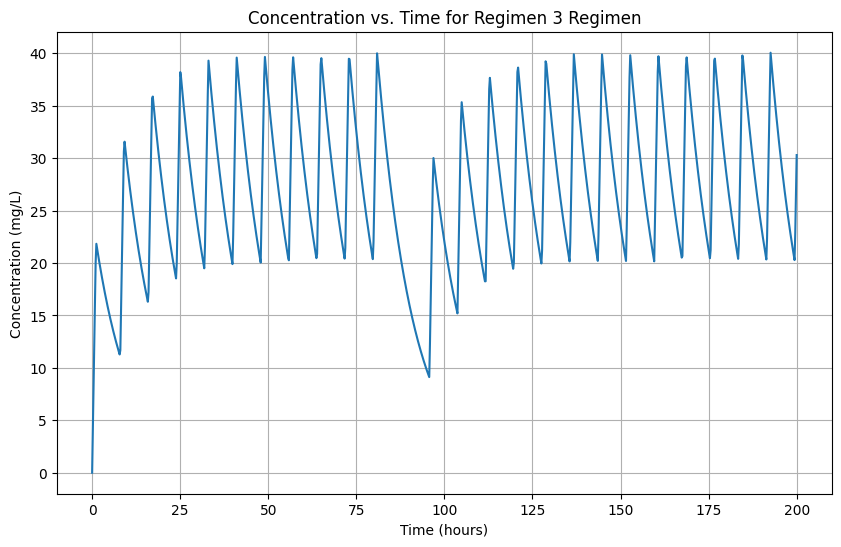

In [2]:
#Visualise simulation results

import random
import matplotlib.pyplot as plt

# Select a regimen at random to visualise
random_profile = concentration_profiles[2]

# Plot the concentration profile for the selected regimen
plt.figure(figsize=(10, 6))
plt.plot(t, random_profile['concentration'])
plt.xlabel('Time (hours)')
plt.ylabel('Concentration (mg/L)')
plt.title(f'Concentration vs. Time for {random_profile["name"]}')
plt.grid(True)
plt.show()

In [12]:
X_train.shape

(9000, 1, 3)

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization,Dropout, Reshape, Conv1D


# Prepare the features and target variable
X = np.array([[regimen['td'], regimen['tdose'], regimen['Udose']] for regimen in parameter_combinations])
y = np.array([profile['concentration'].flatten() for profile in concentration_profiles])

# Reshape X to represent sequences (samples, timesteps, features)
X = X.reshape(X.shape[0], 1, X.shape[1])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Define the neural network architecture
model = Sequential([
    LSTM(64, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Conv1D(padding="same", kernel_size=3, filters=32),
    Flatten(),
    Reshape((1, -1)),
    LSTM(64, activation='relu'),
    Flatten(),
    Reshape((1,-1)),
    LSTM(64, activation='relu'),
    Dense(256, activation='relu'),
    Dense(512, activation='relu'),
    Dense(y_train.shape[1])
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
mse = model.evaluate(X_test, y_test, verbose=0)
print("Mean Squared Error:", mse)


Epoch 1/200
225/225 [==============================] - 8s 14ms/step - loss: 675.0380 - val_loss: 66.9473
Epoch 2/200
225/225 [==============================] - 2s 8ms/step - loss: 62.5914 - val_loss: 60.2712
Epoch 3/200
225/225 [==============================] - 2s 9ms/step - loss: 61.3006 - val_loss: 59.3102
Epoch 4/200
225/225 [==============================] - 2s 9ms/step - loss: 60.9557 - val_loss: 60.1280
Epoch 5/200
225/225 [==============================] - 3s 12ms/step - loss: 60.9100 - val_loss: 58.8224
Epoch 6/200
225/225 [==============================] - 2s 9ms/step - loss: 60.6537 - val_loss: 59.1200
Epoch 7/200
225/225 [==============================] - 2s 8ms/step - loss: 61.0172 - val_loss: 58.9468
Epoch 8/200
225/225 [==============================] - 2s 8ms/step - loss: 62.2070 - val_loss: 58.7941
Epoch 9/200
225/225 [==============================] - 2s 9ms/step - loss: 61.3365 - val_loss: 60.3351
Epoch 10/200
225/225 [==============================] - 2s 9ms/step - 

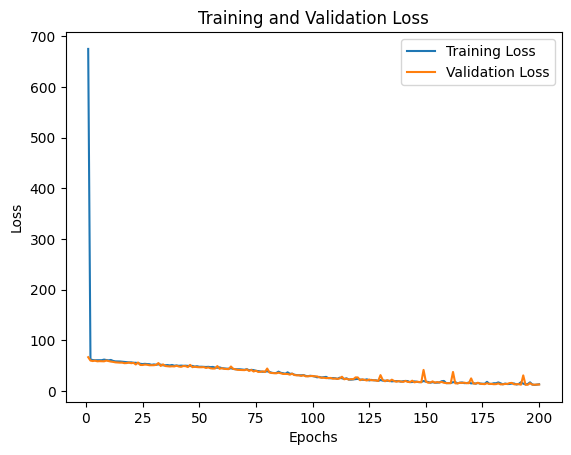

In [19]:
#Plot Losses

# Get the loss history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Plot training and validation loss
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 [==============================] - 0s 19ms/step


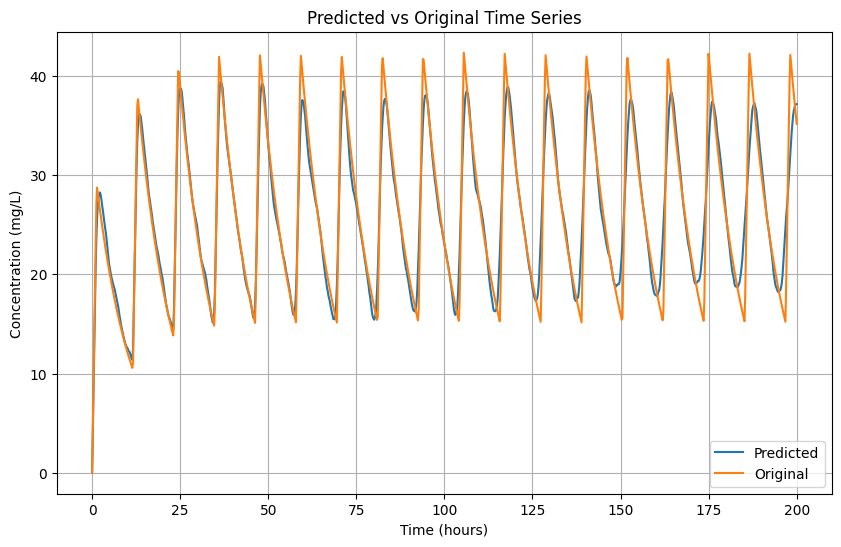

In [22]:
#Visualise predictions for arbitrary parameter combinations

# Choose a random index to select a specific combination of parameters
chosen_index = random.randint(0, len(parameter_combinations) - 1)
chosen_params = parameter_combinations[chosen_index]

# Predict concentration profile using the chosen parameters
chosen_X = np.array([[chosen_params['td'], chosen_params['tdose'], chosen_params['Udose']]])
chosen_X = chosen_X.reshape(chosen_X.shape[0], 1, chosen_X.shape[1])  # Reshape for LSTM input
chosen_y_pred = model.predict(chosen_X).flatten()

# Plot the original and predicted time series
plt.figure(figsize=(10, 6))
plt.plot(t, chosen_y_pred, label='Predicted')
plt.plot(t, concentration_profiles[chosen_index]['concentration'], label='Original')
plt.xlabel('Time (hours)')
plt.ylabel('Concentration (mg/L)')
plt.title('Predicted vs Original Time Series')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#Now we try the same thing with a random forest regressor with Grid Search for best hyperparameters

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# Prepare the features and target variable
X = np.array([[regimen['td'], regimen['tdose'], regimen['Udose']] for regimen in parameter_combinations])

# Reshape the target variable
y = np.array([profile['concentration'].flatten() for profile in concentration_profiles])

# Split the data into training and testing sets
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define the random forest regressor
rf_regressor = RandomForestRegressor()

# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform grid search to find the best parameters
grid_search = GridSearchCV(rf_regressor, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Train the model with the best parameters
best_rf_regressor = RandomForestRegressor(**best_params)
best_rf_regressor.fit(X_train, y_train)

# Predict on the test set
y_pred = best_rf_regressor.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   6.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   5.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   5.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  28.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  28.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  28.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  56.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  56.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  56.2s
[CV] END max_dep

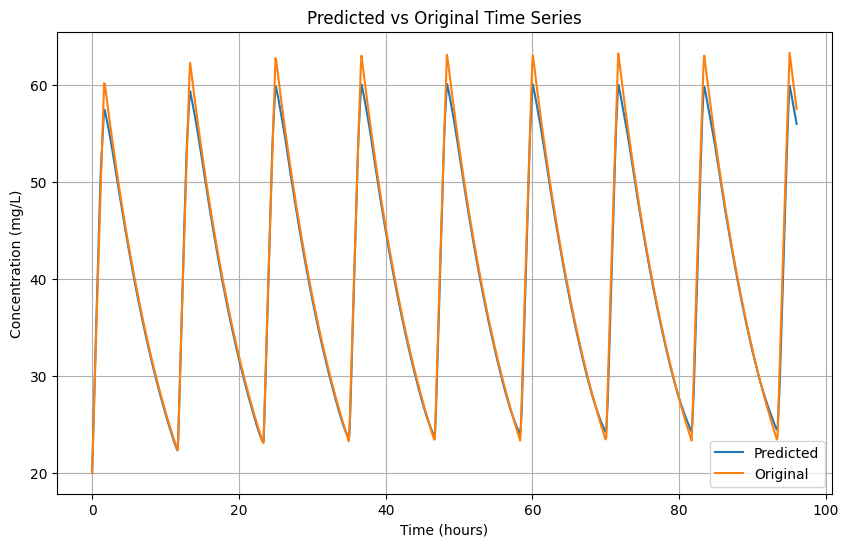

In [ ]:
#Visualise results as before for an arbitrary choice of parameters

# Choose a random index to select a specific combination of parameters
chosen_index = random.randint(0, len(parameter_combinations) - 1)
chosen_params = parameter_combinations[chosen_index]

# Predict concentration profile using the chosen parameters
chosen_X = np.array([chosen_params['td'], chosen_params['tdose'], chosen_params['Udose']]).reshape(1, -1)
chosen_y_pred = best_rf_regressor.predict(chosen_X).flatten()

# Plot the original and predicted time series
plt.figure(figsize=(10, 6))
plt.plot(t, chosen_y_pred, label='Predicted')
plt.plot(t, concentration_profiles[chosen_index]['concentration'], label='Original')
plt.xlabel('Time (hours)')
plt.ylabel('Concentration (mg/L)')
plt.title('Predicted vs Original Time Series')
plt.legend()
plt.grid(True)
plt.show()